# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import pickle

In [2]:
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# load data from database
engine = create_engine('sqlite:///Disaster_Response_Data.db')
df = pd.read_sql("SELECT * FROM messages", engine)
X = df['message']
Y = df.drop(['id', 'message', 'original', 'genre'], axis=1)

In [4]:
pd.set_option('display.max_columns', 100)
df.describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.0,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,15224.82133,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,0.0,0.063778,0.111497,0.088267,0.015449,0.023039,0.011367,0.033377,0.045545,0.131446,0.065037,0.045812,0.050847,0.020293,0.006065,0.010795,0.004577,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,8826.88914,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,0.0,0.244361,0.314752,0.283688,0.123331,0.150031,0.106011,0.179621,0.208500,0.337894,0.246595,0.209081,0.219689,0.141003,0.077643,0.103338,0.067502,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.00000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


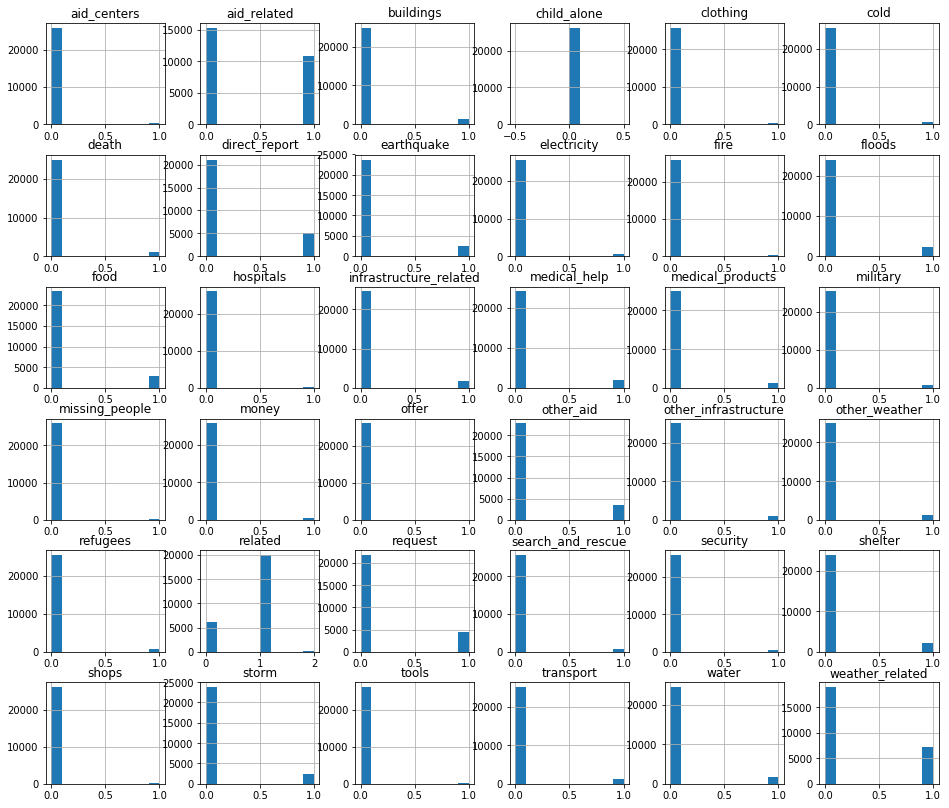

In [5]:
Y.hist(figsize=(16,14));

In [6]:
df['related'].value_counts()

1    19906
0     6122
2      188
Name: related, dtype: int64

In [7]:
df['related']=df['related'].map(lambda x: 1 if x == 2 else x)

In [8]:
df['related'].value_counts()

1    20094
0     6122
Name: related, dtype: int64

In [9]:
X = df['message']
Y = df.drop(['id', 'message', 'original', 'genre'], axis=1)

In [10]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

In [11]:
email_regex = '^[\w\.\+\-]+\@[\w]+\.[a-z]{2,3}$'

### 2. Write a tokenization function to process your text data

In [12]:
def tokenize(text):
    
    
    urls_found = re.findall(url_regex, text)
    emails_found = re.findall(email_regex, text)
    
    for url in urls_found:
        text = text.replace(url, "urlplaceholder")
    
    for email in emails_found:
        text = text.replace(email, "emailplaceholder")
    
    #text = re.sub("[^a-zA-Z0-9]", " ", text)
    
    words = word_tokenize(text)
    
    lemmatizer = WordNetLemmatizer()
    
    tokens_list = []
    
    for word in words:
        word_token = lemmatizer.lemmatize(word).lower().strip()
        tokens_list.append(word_token)
    
    #tokens_list = [w for w in tokens_list if w not in stopwords.words("english")]
    
    #tokens_list = [PorterStemmer().stem(w) for w in tokens_list]
    
    return tokens_list

In [13]:
for message in X[:5]:
    tokens = tokenize(message)
    print(message)
    print(tokens, '\n')

Weather update - a cold front from Cuba that could pass over Haiti
['weather', 'update', '-', 'a', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pas', 'over', 'haiti'] 

Is the Hurricane over or is it not over
['is', 'the', 'hurricane', 'over', 'or', 'is', 'it', 'not', 'over'] 

Looking for someone but no name
['looking', 'for', 'someone', 'but', 'no', 'name'] 

UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
['un', 'report', 'leogane', '80-90', 'destroyed', '.', 'only', 'hospital', 'st.', 'croix', 'functioning', '.', 'needs', 'supply', 'desperately', '.'] 

says: west side of Haiti, rest of the country today and tonight
['say', ':', 'west', 'side', 'of', 'haiti', ',', 'rest', 'of', 'the', 'country', 'today', 'and', 'tonight'] 



### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [14]:
pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('count_vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf_transform', TfidfTransformer())
            ]))

        ])),

        ('classifier', MultiOutputClassifier(RandomForestClassifier()))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True)
model = pipeline.fit(X_train, y_train)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [16]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [17]:
print(classification_report(y_test.values, y_pred_test, target_names=Y.columns.values))

                        precision    recall  f1-score   support

               related       0.84      0.92      0.88      5007
               request       0.81      0.45      0.58      1120
                 offer       0.00      0.00      0.00        27
           aid_related       0.74      0.61      0.67      2716
          medical_help       0.49      0.05      0.09       526
      medical_products       0.71      0.07      0.13       307
     search_and_rescue       0.75      0.05      0.09       178
              security       0.50      0.01      0.02       113
              military       0.51      0.12      0.19       185
           child_alone       0.00      0.00      0.00         0
                 water       0.85      0.29      0.43       421
                  food       0.83      0.45      0.58       708
               shelter       0.82      0.29      0.42       603
              clothing       0.71      0.11      0.19       109
                 money       0.80      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [18]:
print(classification_report(y_train.values, y_pred_train, target_names=Y.columns.values))

                        precision    recall  f1-score   support

               related       0.99      1.00      0.99     15087
               request       1.00      0.92      0.96      3354
                 offer       1.00      0.68      0.81        91
           aid_related       1.00      0.97      0.98      8144
          medical_help       1.00      0.85      0.92      1558
      medical_products       1.00      0.85      0.92      1006
     search_and_rescue       1.00      0.79      0.88       546
              security       0.99      0.72      0.83       358
              military       1.00      0.84      0.91       675
           child_alone       0.00      0.00      0.00         0
                 water       1.00      0.93      0.96      1251
                  food       1.00      0.95      0.97      2215
               shelter       1.00      0.92      0.96      1711
              clothing       1.00      0.86      0.92       296
                 money       1.00      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [14]:
import signal

from contextlib import contextmanager

import requests


DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}


def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler


@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import active session

    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)


def keep_awake(iterable, delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import keep_awake

    for i in keep_awake(range(5)):
        # do iteration with lots of work here
    """
    with active_session(delay, interval): yield from iterable


### 6. Improve your model
Use grid search to find better parameters. 

In [20]:
parameters = {'classifier__estimator__n_estimators': [10, 50, 100],
              'classifier__estimator__max_depth': [5, 10, 20]
              }

with active_session():
    cv = GridSearchCV(pipeline, param_grid=parameters, verbose=1, n_jobs=-1)


cv.fit(X_train, y_train)
#'classifier__estimator__min_samples_split': [2, 3, 4]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 99.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('count_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True,...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'classifier__estimator__n_estimators': [10, 50, 100], 'classifier__estimator__max_depth': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [21]:
pipeline.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('count_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True,...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])>

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [22]:
y_pred_train_cv = cv.predict(X_train)
y_pred_test_cv = cv.predict(X_test)
print(classification_report(y_test.values, y_pred_test_cv, target_names=Y.columns.values))

                        precision    recall  f1-score   support

               related       0.76      1.00      0.87      5007
               request       0.00      0.00      0.00      1120
                 offer       0.00      0.00      0.00        27
           aid_related       0.87      0.02      0.03      2716
          medical_help       0.00      0.00      0.00       526
      medical_products       0.00      0.00      0.00       307
     search_and_rescue       0.00      0.00      0.00       178
              security       0.00      0.00      0.00       113
              military       0.00      0.00      0.00       185
           child_alone       0.00      0.00      0.00         0
                 water       0.00      0.00      0.00       421
                  food       0.00      0.00      0.00       708
               shelter       0.00      0.00      0.00       603
              clothing       0.00      0.00      0.00       109
                 money       0.00      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [23]:
print(classification_report(y_train.values, y_pred_train_cv, target_names=Y.columns.values))

                        precision    recall  f1-score   support

               related       0.77      1.00      0.87     15087
               request       0.00      0.00      0.00      3354
                 offer       0.00      0.00      0.00        91
           aid_related       0.99      0.02      0.04      8144
          medical_help       1.00      0.00      0.00      1558
      medical_products       1.00      0.00      0.00      1006
     search_and_rescue       0.00      0.00      0.00       546
              security       0.00      0.00      0.00       358
              military       0.00      0.00      0.00       675
           child_alone       0.00      0.00      0.00         0
                 water       1.00      0.00      0.00      1251
                  food       1.00      0.00      0.00      2215
               shelter       1.00      0.00      0.00      1711
              clothing       0.00      0.00      0.00       296
                 money       0.00      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [14]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)


In [37]:
pipeline_new = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('count_vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf_transform', TfidfTransformer())
            ])),
            
             ('starting_verb', StartingVerbExtractor())

        ])),

        ('classifier', MultiOutputClassifier(AdaBoostClassifier()))
    ])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True)

parameters_new = {'classifier__estimator__learning_rate': [0.01, 0.03, 0.1],
                       'classifier__estimator__n_estimators': [8, 16, 32]}

with active_session():
    cv_new = GridSearchCV(pipeline_new, param_grid=parameters_new, verbose=1, n_jobs=-1)


cv_new.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 60.6min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('count_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True,...mator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'classifier__estimator__learning_rate': [0.01, 0.03, 0.1], 'classifier__estimator__n_estimators': [8, 16, 32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [42]:
print(cv_new.best_params_)

{'classifier__estimator__learning_rate': 0.1, 'classifier__estimator__n_estimators': 32}


In [39]:
y_pred_train_cv_new = cv_new.predict(X_train)
y_pred_test_cv_new = cv_new.predict(X_test)
print(classification_report(y_test.values, y_pred_test_cv_new, target_names=Y.columns.values))

                        precision    recall  f1-score   support

               related       0.76      1.00      0.86      4992
               request       0.91      0.28      0.42      1122
                 offer       0.00      0.00      0.00        20
           aid_related       0.80      0.31      0.44      2727
          medical_help       0.85      0.02      0.04       539
      medical_products       0.83      0.03      0.05       355
     search_and_rescue       1.00      0.02      0.03       177
              security       0.00      0.00      0.00       120
              military       0.00      0.00      0.00       247
           child_alone       0.00      0.00      0.00         0
                 water       0.83      0.48      0.61       438
                  food       0.76      0.68      0.72       723
               shelter       0.81      0.29      0.43       574
              clothing       0.86      0.20      0.32        90
                 money       1.00      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [40]:
print(classification_report(y_train.values, y_pred_train_cv_new, target_names=Y.columns.values))

                        precision    recall  f1-score   support

               related       0.77      1.00      0.87     15102
               request       0.88      0.25      0.38      3352
                 offer       0.00      0.00      0.00        98
           aid_related       0.80      0.31      0.45      8133
          medical_help       0.78      0.01      0.02      1545
      medical_products       0.78      0.02      0.04       958
     search_and_rescue       0.90      0.02      0.03       547
              security       0.00      0.00      0.00       351
              military       0.00      0.00      0.00       613
           child_alone       0.00      0.00      0.00         0
                 water       0.84      0.47      0.60      1234
                  food       0.78      0.68      0.72      2200
               shelter       0.85      0.31      0.46      1740
              clothing       0.70      0.10      0.18       315
                 money       1.00      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 9. Export your model as a pickle file

In [18]:
with open('classifier.pkl', 'wb') as f:
    pickle.dump(cv_new, f)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [21]:
with open('classifier.pkl', 'rb') as f:
    model = pickle.load(f)